<a href="https://colab.research.google.com/github/rukmals/crowd-monitoring-system-model-development/blob/main/load_GCC_gt_as_csv_and_and_train_the_model_with_backend_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=d248405eccd765b091086bb5e6a84afc68bca5909485bd9e044168b493220b0e
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 26.3 GB  | Proc size: 118.6 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [4]:
import random
import os
from PIL import Image,ImageFilter,ImageDraw
import numpy as np
import h5py
from PIL import ImageStat
import glob
import json

import sys
import warnings
# import from library
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
import argparse
import json
import cv2
import time
from torchvision import models

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, \
                stride=1, NL='relu', same_padding=False, bn=False, dilation=1):
        super(Conv2d, self).__init__()
        padding = int((kernel_size - 1) // 2) if same_padding else 0
        self.conv = []
        if dilation==1:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=padding, dilation=dilation)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=dilation, dilation=dilation)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0, affine=True) if bn else nn.Identity()
        if NL == 'relu' :
            self.relu = nn.ReLU(inplace=True)
        elif NL == 'prelu':
            self.relu = nn.PReLU()
        else:
            self.relu = None

    def forward(self, x):
      x = self.conv(x)
      if self.bn is not None:
          x = self.bn(x)
      if self.relu is not None:
          x = self.relu(x)   
      return x
  
# the module definition for the multi-branch in the density head
class MultiBranchModule(nn.Module):
    def __init__(self, in_channels, sync=False):
        super(MultiBranchModule, self).__init__()
        self.branch_column1_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column1_2 = BasicConv2d(in_channels//2, in_channels, kernel_size=1, sync=sync)

        self.branch_column2_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column2_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=(3, 3), padding=(1, 1), sync=sync)

        self.branch_column3_1 = BasicConv2d(in_channels, in_channels//2, kernel_size=1, sync=sync)
        self.branch_column3_2 = BasicConv2d(in_channels // 2, in_channels, kernel_size=5, padding=2, sync=sync)

    def forward(self, x):
        branch_1 = self.branch_column1_1(x)
        branch_1 = self.branch_column1_2(branch_1)

        branch_2 = self.branch_column2_1(x)
        branch_2 = self.branch_column2_2(branch_2)

        branch_3 = self.branch_column3_1(x)
        branch_3 = self.branch_column3_2(branch_3)

        outputs = [branch_1, branch_2, branch_3, x]
        return torch.cat(outputs, 1)

# the module definition for the basic conv module
class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, sync=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        if sync:
            # for sync bn
            print('use sync inception')
            self.bn = nn.SyncBatchNorm(out_channels, eps=0.001)
        else:
            self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class TestNet(nn.Module):
    def __init__(self, pretrained=True):
        super(TestNet, self).__init__()
        
        vgg = models.vgg16_bn(pretrained=pretrained)
        
        self.backend_feat  = [256,128,64]


        # Front End Development VGG - 16 
        features = list(vgg.features.children())
        # get each stage of the VGG - 16
        self.features1 = nn.Sequential(*features[0:6])
        self.features2 = nn.Sequential(*features[6:13])
        self.features3 = nn.Sequential(*features[13:23])
        self.features4 = nn.Sequential(*features[23:33])
        self.features5 = nn.Sequential(*features[33:43])

        # Front End Development P1 to P5 
        self.p5 = nn.Sequential(
            Conv2d(512, 1024, 3, same_padding=True, NL='relu'),
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
        )

        self.p4 = nn.Sequential(
            Conv2d(1024, 512, 3, same_padding=True, NL='relu'),
            Conv2d(512, 256, 3, same_padding=True, NL='relu'),
        )

        self.p3 = nn.Sequential(
            Conv2d(512 , 256, 3, same_padding=True, NL='relu'),
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
        )

        self.p2 = nn.Sequential(
            Conv2d(256, 128, 3, same_padding=True, NL='relu'),
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
        )

        self.p1 = nn.Sequential(
            Conv2d(128, 64, 3, same_padding=True, NL='relu'),
            Conv2d(64, 64, 3, same_padding=True, NL='relu'),
        ) 

        # Multi-Branch moules
        self.multi_branch5 = nn.Sequential(
            MultiBranchModule(512),
            Conv2d(2048, 1, 1, same_padding=True)
        )

        self.multi_branch4 = nn.Sequential(
            MultiBranchModule(256),
            Conv2d(1024, 1, 1, same_padding=True)
        )

        self.multi_branch3 = nn.Sequential(
            MultiBranchModule(128),
            Conv2d(512, 1, 1, same_padding=True)
        )

        self.multi_branch2 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.multi_branch1 = nn.Sequential(
            MultiBranchModule(64),
            Conv2d(256, 1, 1, same_padding=True)
        )

        self.backend = make_layers(self.backend_feat,in_channels = 5,dilation = True)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    
    
    def forward(self, x):
        size = x.size()
        x1 = self.features1(x)
        x2 = self.features2(x1)
        x3 = self.features3(x2)
        x4 = self.features4(x3)
        x5 = self.features5(x4)

        # Front End Development P1 to P5 
        x = self.p5(x5)
        x5_out = x
        x = F.upsample_bilinear(x, size=x4.size()[2:])

        x = torch.cat([x4, x], 1)
        x = self.p4(x)
        x4_out = x
        x = F.upsample_bilinear(x, size=x3.size()[2:])

        x = torch.cat([x3, x], 1)
        x = self.p3(x)
        x3_out = x
        x = F.upsample_bilinear(x, size=x2.size()[2:])

        x = torch.cat([x2, x], 1)
        x = self.p2(x)
        x2_out = x
        x = F.upsample_bilinear(x, size=x1.size()[2:])

        x = torch.cat([x1, x], 1)
        x = self.p1(x)
        x1_out = x


        # multi-branch predictions
        x5_density = self.multi_branch5(x5_out)
        x4_density = self.multi_branch4(x4_out)
        x3_density = self.multi_branch3(x3_out)
        x2_density = self.multi_branch2(x2_out)
        x1_density = self.multi_branch1(x1_out)

        # upsample the multi-branch predictions to be the same with the input size
        x5_density = F.upsample_nearest(x5_density, size=x1.size()[2:])
        x4_density = F.upsample_nearest(x4_density, size=x1.size()[2:])
        x3_density = F.upsample_nearest(x3_density, size=x1.size()[2:])
        x2_density = F.upsample_nearest(x2_density, size=x1.size()[2:])
        x1_density = F.upsample_nearest(x1_density, size=x1.size()[2:])


        density_map = torch.cat([x5_density, x4_density, x3_density, x2_density, x1_density], 1)


        x_out = self.backend(density_map)
        density_map_out = self.output_layer(x_out)
        return density_map_out
        #return density_map
                
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    layers = []
    dilation_rates = [2,3,5]
    #for v in cfg:
    for v in range(len(cfg)):
        if cfg[v] == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, cfg[v], kernel_size=3, padding=dilation_rates[v],dilation = dilation_rates[v])
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(cfg[v]), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = cfg[v]
    return nn.Sequential(*layers)

In [6]:
import numbers
import random
import numpy as np
from PIL import Image, ImageOps, ImageFilter
import torch

class LabelNormalize(object):
    def __init__(self, para):
        self.para = para

    def __call__(self, tensor):
        # tensor = 1./(tensor+self.para).log()
        tensor = torch.from_numpy(np.array(tensor))
        tensor = tensor*self.para
        return tensor


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, mask, bbx=None):
        if bbx is None:
            for t in self.transforms:
                img, mask = t(img, mask)
            return img, mask
        for t in self.transforms:
            img, mask, bbx = t(img, mask, bbx)
        return img, mask, bbx

class RandomHorizontallyFlip(object):
    def __call__(self, img, mask, bbx=None):
        if random.random() < 0.5:
            if bbx is None:
                return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT)
            w, h = img.size
            xmin = w - bbx[:,3]
            xmax = w - bbx[:,1]
            bbx[:,1] = xmin
            bbx[:,3] = xmax
            return img.transpose(Image.FLIP_LEFT_RIGHT), mask.transpose(Image.FLIP_LEFT_RIGHT), bbx
        if bbx is None:
            return img, mask
        return img, mask, bbx

class RandomCrop(object):
    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, img, mask):

        w, h = img.size
        th, tw  = self.size
        if w == tw and h == th:
            return img, mask
        if w < tw or h < th:
            return img.resize((tw, th), Image.BILINEAR), mask.resize((tw, th), Image.NEAREST)

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return img.crop((x1, y1, x1 + tw, y1 + th)), mask.crop((x1, y1, x1 + tw, y1 + th))

In [7]:
import os
import random
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from PIL import Image

def load_data(img_path,train = True):
    #path = "/content/drive/MyDrive/GCC_CSV_DataSet/Part 0/scene_00_0/csv_den_maps_k15_s4_544_960"
    gt_path = img_path.replace('.png','.csv').replace('pngs_544_960','csv_den_maps_k15_s4_544_960')
    img = Image.open(img_path)
    target = pd.read_csv(gt_path, sep=',', header=None).values
    target = target.astype(np.float32, copy=False)
    target = Image.fromarray(target)
    return img,target


class ListDataset(Dataset):
    def __init__(self, root, shape=None, shuffle=True, main_transform = None , img_transform=None, gt_transform = None, train=False, batch_size=1, num_workers=4):
        """
        if you have different image size, then batch_size must be 1
        :param root:
        :param shape:
        :param shuffle:
        :param transform:
        :param train:
        :param seen:
        :param batch_size:
        :param num_workers:
        """
        #if train:
            #root = root *4
        if shuffle:
            random.shuffle(root)
        
        self.nSamples = len(root)
        self.lines = root
        self.main_transform = main_transform
        self.img_transform = img_transform
        self.gt_transform = gt_transform
        self.train = train
        self.shape = shape
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error' 
        
        img_path = self.lines[index]
        
        img,target = load_data(img_path,self.train)

        if self.main_transform is not None:
            img, target = self.main_transform(img, target)
        if self.img_transform is not None:
            img = self.img_transform(img)
        if self.gt_transform is not None:
            target = self.gt_transform(target)   
        return img,target

In [8]:
model = TestNet()
model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [9]:
def get_image_path(file_path):
  file_path_list = file_path.split(" ")
  scene = file_path_list[3][4:]
  image_number = file_path_list[4]
  image_path = "/content/drive/MyDrive/GCC_CSV_DataSet/"+"Part"+"_"+scene[7]+scene+"/"+"pngs_544_960/"+image_number+".png"
  return image_path
  
def get_image_pathlist(path_list, part):
    image_path_list_part_ = []
    for line_ in path_list:
        if line_.find(part)!=-1:
            image_path_list_part_.append(line_)
    return image_path_list_part_

def extract_image_path_list(image_file, part):
  file_ = open(image_file, 'r')
  file_list = file_.readlines()
  image_path_list_train = []  
  for line in file_list:
      image_path_list_train.append(get_image_path(line))
  train_list = get_image_pathlist(image_path_list_train, part)
  print("data size: ",len(train_list))
  return train_list



In [10]:
train_list = '/content/drive/MyDrive/GCC/train_list.txt'
part0_train_list = extract_image_path_list(train_list, "Part_0")
part1_train_list = extract_image_path_list(train_list, "Part_1")
part2_train_list = extract_image_path_list(train_list, "Part_2")
part3_train_list = extract_image_path_list(train_list, "Part_3")
part4_train_list = extract_image_path_list(train_list, "Part_4")
part5_train_list = extract_image_path_list(train_list, "Part_5")
part6_train_list = extract_image_path_list(train_list, "Part_6")
part7_train_list = extract_image_path_list(train_list, "Part_7")
part8_train_list = extract_image_path_list(train_list, "Part_8")
part9_train_list = extract_image_path_list(train_list, "Part_9")

data size:  1320
data size:  1160
data size:  1258
data size:  1135
data size:  1055
data size:  1037
data size:  1000
data size:  1026
data size:  992
data size:  1461


In [11]:
test_list = '/content/drive/MyDrive/GCC/test_list.txt'
part0_test_list = extract_image_path_list(test_list, "Part_0")
part1_test_list = extract_image_path_list(test_list, "Part_1")
part2_test_list = extract_image_path_list(test_list, "Part_2")
part3_test_list = extract_image_path_list(test_list, "Part_3")
part4_test_list = extract_image_path_list(test_list, "Part_4")
part5_test_list = extract_image_path_list(test_list, "Part_5")
part6_test_list = extract_image_path_list(test_list, "Part_6")
part7_test_list = extract_image_path_list(test_list, "Part_7")
part8_test_list = extract_image_path_list(test_list, "Part_8")
part9_test_list = extract_image_path_list(test_list, "Part_9")

data size:  473
data size:  385
data size:  415
data size:  368
data size:  356
data size:  335
data size:  341
data size:  322
data size:  335
data size:  438


In [12]:
train_data = part0_train_list + part1_train_list+part2_train_list+part3_train_list+part4_train_list+part5_train_list+part6_train_list+part7_train_list+part8_train_list+part9_train_list
test_data = part0_test_list + part1_test_list+part2_test_list+part3_test_list+part4_test_list+part5_test_list+part6_test_list+part7_test_list+part8_test_list+part9_test_list

In [13]:
sou_main_transform = Compose([
        RandomCrop((480,480)),
        RandomHorizontallyFlip(),
        # Rand_Augment()
    ])
train_loader = torch.utils.data.DataLoader(ListDataset(train_data,shuffle=True,
                                                                main_transform = sou_main_transform,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [14]:
test_loader = torch.utils.data.DataLoader(ListDataset(test_data,shuffle=False,
                                                                main_transform = None,
                                                                img_transform=transforms.Compose([
                                                                transforms.ToTensor(), 
                                                                transforms.Normalize(mean=[0.302234709263, 0.291243076324, 0.269087553024],
                                                                                 std=[0.227743327618, 0.211051672697, 0.184846073389]),
                                                                ]),
                                                                gt_transform = transforms.Compose([
                                                                                LabelNormalize(100)
                                                                ]),
                                                                train=True,
                                                                batch_size=2,
                                                                num_workers=2),batch_size=2)

In [15]:
lr = 1e-5
criterion = nn.MSELoss(size_average=False).cuda()

#optimizer = torch.optim.SGD(model.parameters(), lr,momentum=0.95,weight_decay=5 * 1e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.98)

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.cur_val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, cur_val):
        self.cur_val = cur_val
        self.sum += cur_val
        self.count += 1
        self.avg = self.sum / self.count

In [17]:

def mae_mse_update(pred,label,maes,mses=None,ssims=None,psnrs=None,losses=None,cls_id=None):
        for num in range(pred.size()[0]):
            sub_pred = pred[num].data.cpu().squeeze().numpy()/ 100
            sub_label = label[num].data.cpu().squeeze().numpy() / 100
            pred_cnt = np.sum(sub_pred)
            gt_cnt =   np.sum(sub_label)
            mae = abs(pred_cnt - gt_cnt)
            mse = (pred_cnt - gt_cnt)*(pred_cnt - gt_cnt)

            if ssims and psnrs is not None:
                ssims.update(get_ssim(sub_label,sub_pred))
                psnrs.update(get_psnr(sub_label,sub_pred))

            if cls_id is not None:
                maes.update(mae,cls_id)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item(),cls_id)
                if mses is not None:
                    mses.update(mse,cls_id)
            else:
                maes.update(mae)
                if losses is not None:
                    loss = F.mse_loss(pred.detach().squeeze(), label.detach().squeeze())
                    losses.update(loss.item())
                if mses is not None:
                    mses.update(mse)

        return pred_cnt,gt_cnt

In [20]:
PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNet_checkpoint_gcc_data_Whole_aug.pth'
end_epoch = 100
start_epoch = 0
if (os.path.isfile(PATH))==True:
  checkpoint = torch.load(PATH)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  start_epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("Successfully load the check point")
else:
  print("No check point Available!!!")
print(end_epoch , start_epoch)

Successfully load the check point
100 59


In [21]:
train_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/train_mae_part1and0.txt","a")
test_mae_file = open("/content/drive/MyDrive/GCC_CSV_DataSet/test_mae_part1and0.txt","a")
train_mae_file.truncate(0)
test_mae_file.truncate(0)

0

In [22]:
test_best_mae = 34.53

In [ ]:
for epoch in range(start_epoch,end_epoch):
    losses = AverageMeter()
    model.train()
    train_mae = AverageMeter()
    train_mse = AverageMeter()
    for i, (img, target) in enumerate(train_loader):

        img = img.cuda()
        img = Variable(img) 
        output = model(img)

        loss = criterion(output.squeeze(), target.squeeze().cuda())
        losses.update(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sou_pred_cnt, sou_label_cnt = mae_mse_update(output, target, train_mae, train_mse)
        if i % 1000 == 0:
            print('Epoch {}, Loss={:.4f} s_gt={:.1f} s_pre={:.1f}, lr={:.4f}'.format(
                    epoch, loss.item(), sou_label_cnt,sou_pred_cnt, optimizer.param_groups[0]['lr']*10000))
    
    scheduler.step()  
    print('train_mae_sou', float(train_mae.avg), epoch)
    print('train_mse_sou', float(np.sqrt(train_mse.avg)), epoch)
    train_mae_file.write(str(train_mae.avg))
    train_mae_file.write("\n")
  
    print("testing...................")  
    with torch.no_grad():
      model.eval()
      test_mae = AverageMeter()
      test_mse = AverageMeter()
      for j, (img_test, target_test) in enumerate(test_loader):
          img_test = img_test.cuda()
          img_test = Variable(img_test)   
          output_test = model(img_test)

          sou_pred_cnt_test, sou_label_cnt_test = mae_mse_update(output_test, target_test, test_mae, test_mse)
          if j % 1000 == 0:
            print('Epoch {}, s_gt={:.1f} s_pre={:.1f} '.format(epoch, sou_label_cnt_test,sou_pred_cnt_test))
      print('test_mae_sou', float(test_mae.avg), epoch)
      print('test_mse_sou', float(np.sqrt(test_mse.avg)), epoch)
      if test_mae.avg<test_best_mae:
        test_best_mae = test_mae.avg
        print("Best Train MAE", test_best_mae)
        MODEL_SAVE_PATH = '/content/drive/MyDrive/GCC_CSV_DataSet/model/TestNetGCC_whole_data_withbackend_4.pth'
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
      test_mae_file.write(str(test_mae.avg))
      test_mae_file.write("\n")
      torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, PATH) 

train_mae_file.close()
test_mae_file.close()


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3770: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


Epoch 59, Loss=19902.6836 s_gt=82.1 s_pre=73.7, lr=0.0695
Epoch 59, Loss=7282.2490 s_gt=430.6 s_pre=455.6, lr=0.0695
Epoch 59, Loss=287.4172 s_gt=6.0 s_pre=2.0, lr=0.0695
Epoch 59, Loss=12248.0566 s_gt=456.4 s_pre=499.6, lr=0.0695
Epoch 59, Loss=4582.2256 s_gt=169.4 s_pre=182.6, lr=0.0695
Epoch 59, Loss=3643.0664 s_gt=151.1 s_pre=136.9, lr=0.0695
train_mae_sou 16.327968646574615 59
train_mse_sou 33.42070793976988 59
testing...................
Epoch 59, s_gt=1895.6 s_pre=1939.6 
Epoch 59, s_gt=565.7 s_pre=502.0 
test_mae_sou 34.53905155540952 59
test_mse_sou 99.81495566663979 59
Best Train MAE 34.53905155540952
Epoch 60, Loss=14107.3301 s_gt=16.6 s_pre=19.2, lr=0.0695
Epoch 60, Loss=8043.8760 s_gt=473.7 s_pre=443.6, lr=0.0695
Epoch 60, Loss=190.7661 s_gt=6.0 s_pre=-1.9, lr=0.0695
Epoch 60, Loss=6555.2295 s_gt=384.4 s_pre=375.6, lr=0.0695
Epoch 60, Loss=3388.7014 s_gt=150.2 s_pre=138.0, lr=0.0695
Epoch 60, Loss=4562.0576 s_gt=204.9 s_pre=201.9, lr=0.0695
train_mae_sou 15.74676398901358 6

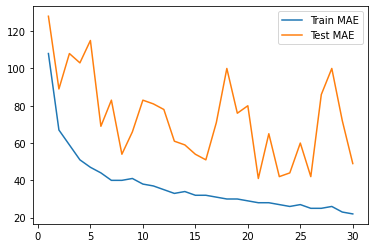

In [ ]:
import matplotlib.pyplot as plt


x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
y1 = [108 ,67]+[59, 51, 47]+[44, 40, 40 , 41,38,37 , 35,33,34,32,32,31,30,30,29,28,28,27,26,27,25,25 , 26 , 23 , 22 , 24, 23,22,21]
y2 = [128,89]+[108, 103, 115]+[69, 83, 54,66 , 83,81,78,61,59,54 ,51,71,100,76,80,41,65,42,44,60,42,86 , 100 , 72 , 49 , 60, 75,65,50]
plt.plot(x1, y1)
plt.plot(x1, y2)

plt.legend(["Train MAE", "Test MAE"])

In [ ]:
Epoch 34, Loss=838.7301 s_gt=4.0 s_pre=1.6, lr=0.0868
Epoch 34, Loss=1473.2112 s_gt=64.8 s_pre=73.4, lr=0.0868
Epoch 34, Loss=40504.1172 s_gt=775.4 s_pre=833.0, lr=0.0868
Epoch 34, Loss=2083.0842 s_gt=140.5 s_pre=151.5, lr=0.0868
Epoch 34, Loss=345.8074 s_gt=5.0 s_pre=0.9, lr=0.0868
Epoch 34, Loss=97.8701 s_gt=0.0 s_pre=7.5, lr=0.0868
train_mae_sou 21.68008467519629 34
train_mse_sou 46.00234074912981 34
testing...................
Epoch 34, s_gt=1895.6 s_pre=1898.6 
Epoch 34, s_gt=565.7 s_pre=542.5 
test_mae_sou 38.12453779647811 34
test_mse_sou 104.26148414504028 34
Best Train MAE 38.12453779647811
Epoch 35, Loss=1173.7349 s_gt=8.0 s_pre=6.8, lr=0.0868
Epoch 35, Loss=1948.0869 s_gt=99.1 s_pre=102.8, lr=0.0868
Epoch 35, Loss=71451.7031 s_gt=301.3 s_pre=301.1, lr=0.0868
Epoch 35, Loss=3164.8726 s_gt=219.5 s_pre=222.2, lr=0.0868
Epoch 35, Loss=333.1918 s_gt=4.0 s_pre=-1.4, lr=0.0868
Epoch 35, Loss=71.3515 s_gt=0.0 s_pre=1.6, lr=0.0868
train_mae_sou 20.46233996267931 35
train_mse_sou 42.4908600710243 35
testing...................
Epoch 35, s_gt=1895.6 s_pre=1900.8 
Epoch 35, s_gt=565.7 s_pre=546.9 
test_mae_sou 43.22552659607744 35
test_mse_sou 106.72734335196898 35
Epoch 36, Loss=946.5880 s_gt=4.0 s_pre=-3.2, lr=0.0851
Epoch 36, Loss=1688.1697 s_gt=104.7 s_pre=116.6, lr=0.0851
Epoch 36, Loss=68379.1406 s_gt=274.5 s_pre=307.1, lr=0.0851
Epoch 36, Loss=3174.0962 s_gt=169.8 s_pre=172.4, lr=0.0851
Epoch 36, Loss=211.9631 s_gt=5.0 s_pre=1.0, lr=0.0851
Epoch 36, Loss=332.6659 s_gt=3.6 s_pre=9.2, lr=0.0851
train_mae_sou 19.791974895481086 36
train_mse_sou 40.12480115773305 36
testing...................
Epoch 36, s_gt=1895.6 s_pre=1979.2 
Epoch 36, s_gt=565.7 s_pre=536.9 
test_mae_sou 45.17166818491719 36
test_mse_sou 109.43994664537614 36
Epoch 37, Loss=584.0137 s_gt=4.0 s_pre=-1.1, lr=0.0851
Epoch 37, Loss=1738.9751 s_gt=93.3 s_pre=98.3, lr=0.0851
Epoch 37, Loss=82252.5469 s_gt=189.3 s_pre=212.5, lr=0.0851
Epoch 37, Loss=763.6407 s_gt=72.4 s_pre=73.6, lr=0.0851
Epoch 37, Loss=139.1077 s_gt=4.0 s_pre=4.9, lr=0.0851
Epoch 37, Loss=315.2029 s_gt=4.0 s_pre=17.3, lr=0.0851
train_mae_sou 20.33172571799161 37
train_mse_sou 40.88122889580557 37
testing...................
Epoch 37, s_gt=1895.6 s_pre=2037.0 
Epoch 37, s_gt=565.7 s_pre=524.8 
test_mae_sou 45.04595815781069 37
test_mse_sou 113.8307009930094 37

38 - > 21 , 51
39 -> 20 , 41

Epoch 40, Loss=8304.2939 s_gt=404.6 s_pre=432.4, lr=0.0817
Epoch 40, Loss=70732.7656 s_gt=1124.0 s_pre=977.5, lr=0.0817
Epoch 40, Loss=13326.2207 s_gt=445.3 s_pre=438.6, lr=0.0817
Epoch 40, Loss=24181.6406 s_gt=5.0 s_pre=8.0, lr=0.0817
Epoch 40, Loss=49174.3711 s_gt=1952.2 s_pre=1989.9, lr=0.0817
Epoch 40, Loss=133.8483 s_gt=2.0 s_pre=3.6, lr=0.0817
train_mae_sou 19.744896203239943 40
train_mse_sou 41.813694181772334 40
testing...................
Epoch 40, s_gt=1895.6 s_pre=1641.7 
Epoch 40, s_gt=565.7 s_pre=404.8 
test_mae_sou 93.03111563676735 40
test_mse_sou 175.85595945273909 40
Epoch 41, Loss=5355.8091 s_gt=240.6 s_pre=227.7, lr=0.0817
Epoch 41, Loss=87352.8828 s_gt=2383.5 s_pre=2517.5, lr=0.0817
Epoch 41, Loss=9957.2109 s_gt=548.9 s_pre=604.1, lr=0.0817
Epoch 41, Loss=32884.8477 s_gt=7.2 s_pre=7.1, lr=0.0817
Epoch 41, Loss=24948.9141 s_gt=1429.5 s_pre=1428.1, lr=0.0817
Epoch 41, Loss=358.5166 s_gt=5.0 s_pre=8.0, lr=0.0817
train_mae_sou 19.20208520769431 41
train_mse_sou 39.09603364983059 41
testing...................
Epoch 41, s_gt=1895.6 s_pre=1945.7 
Epoch 41, s_gt=565.7 s_pre=524.7 
test_mae_sou 42.867559874639895 41
test_mse_sou 106.08307716189252 41

Epoch 42, Loss=10587.0488 s_gt=631.6 s_pre=632.8, lr=0.0801
Epoch 42, Loss=7205.1714 s_gt=13.7 s_pre=26.1, lr=0.0801
Epoch 42, Loss=1611.0638 s_gt=107.0 s_pre=101.6, lr=0.0801
Epoch 42, Loss=1374.4102 s_gt=57.9 s_pre=46.4, lr=0.0801
Epoch 42, Loss=3499.4077 s_gt=257.6 s_pre=249.2, lr=0.0801
Epoch 42, Loss=7475.5840 s_gt=181.9 s_pre=187.5, lr=0.0801
train_mae_sou 19.249811987702177 42
train_mse_sou 39.24659352626645 42
testing...................
Epoch 42, s_gt=1895.6 s_pre=1744.6 
Epoch 42, s_gt=565.7 s_pre=464.8 
test_mae_sou 73.63870462212087 42
test_mse_sou 173.15758771065885 42
Epoch 43, Loss=8999.1592 s_gt=532.7 s_pre=513.6, lr=0.0801
Epoch 43, Loss=5948.3691 s_gt=12.0 s_pre=6.1, lr=0.0801
Epoch 43, Loss=1690.8459 s_gt=115.2 s_pre=120.9, lr=0.0801
Epoch 43, Loss=1292.7081 s_gt=40.6 s_pre=24.4, lr=0.0801
Epoch 43, Loss=4475.7832 s_gt=284.2 s_pre=276.1, lr=0.0801
Epoch 43, Loss=14242.4180 s_gt=454.7 s_pre=430.3, lr=0.0801
train_mae_sou 19.112811106155903 43
train_mse_sou 38.755274151188786 43
testing...................
Epoch 43, s_gt=1895.6 s_pre=1851.1 
Epoch 43, s_gt=565.7 s_pre=490.8 
test_mae_sou 62.279909163523634 43
test_mse_sou 148.66144995674944 43
Epoch 44, Loss=13803.9580 s_gt=627.2 s_pre=587.4, lr=0.0785
Epoch 44, Loss=6162.7754 s_gt=7.0 s_pre=6.9, lr=0.0785
Epoch 44, Loss=2305.2659 s_gt=174.1 s_pre=170.3, lr=0.0785
Epoch 44, Loss=1612.7783 s_gt=67.0 s_pre=50.4, lr=0.0785
Epoch 44, Loss=4462.7485 s_gt=300.5 s_pre=317.0, lr=0.0785
Epoch 44, Loss=29199.8672 s_gt=763.4 s_pre=739.8, lr=0.0785
train_mae_sou 18.486550482899492 44
train_mse_sou 38.131654998596616 44
testing...................
Epoch 44, s_gt=1895.6 s_pre=1879.8 
Epoch 44, s_gt=565.7 s_pre=531.4 
test_mae_sou 85.00807846782061 44
test_mse_sou 190.98673611210333 44
Epoch 45, Loss=9988.3516 s_gt=566.6 s_pre=564.4, lr=0.0785
Epoch 45, Loss=7176.6543 s_gt=11.0 s_pre=29.0, lr=0.0785
Epoch 45, Loss=1275.6458 s_gt=83.0 s_pre=79.5, lr=0.0785
Epoch 45, Loss=1313.6364 s_gt=52.5 s_pre=39.8, lr=0.0785
Epoch 45, Loss=3059.4463 s_gt=214.2 s_pre=206.5, lr=0.0785
Epoch 45, Loss=25529.0430 s_gt=613.5 s_pre=584.5, lr=0.0785
train_mae_sou 17.763976986277477 45
train_mse_sou 36.08759365320786 45
testing...................
Epoch 45, s_gt=1895.6 s_pre=1889.0 
Epoch 45, s_gt=565.7 s_pre=500.4 
test_mae_sou 56.785694070555856 45
test_mse_sou 147.39948246694553 45

Epoch 46, Loss=20192.4707 s_gt=669.0 s_pre=662.3, lr=0.0769
Epoch 46, Loss=28775.1328 s_gt=601.7 s_pre=584.8, lr=0.0769
Epoch 46, Loss=11500.4805 s_gt=211.5 s_pre=210.4, lr=0.0769
Epoch 46, Loss=200.9137 s_gt=6.0 s_pre=2.7, lr=0.0769
Epoch 46, Loss=51790.4414 s_gt=1023.5 s_pre=1098.2, lr=0.0769
Epoch 46, Loss=1284.9531 s_gt=3.0 s_pre=1.1, lr=0.0769
train_mae_sou 18.32313086290561 46
train_mse_sou 37.24982352938425 46
testing...................
Epoch 46, s_gt=1895.6 s_pre=1872.4 
Epoch 46, s_gt=565.7 s_pre=521.2 
test_mae_sou 42.52987863101271 46
test_mse_sou 92.23180429646341 46
Epoch 47, Loss=11549.1543 s_gt=283.7 s_pre=293.7, lr=0.0769
Epoch 47, Loss=32423.1621 s_gt=704.4 s_pre=717.6, lr=0.0769
Epoch 47, Loss=15759.1221 s_gt=43.5 s_pre=39.3, lr=0.0769
Epoch 47, Loss=46.3543 s_gt=4.0 s_pre=2.3, lr=0.0769
Epoch 47, Loss=94463.4688 s_gt=2203.3 s_pre=2096.7, lr=0.0769
Epoch 47, Loss=6149.9253 s_gt=83.5 s_pre=99.5, lr=0.0769
train_mae_sou 17.97119231794831 47
train_mse_sou 37.668697703727844 47
testing...................
Epoch 47, s_gt=1895.6 s_pre=2036.5 
Epoch 47, s_gt=565.7 s_pre=486.7 
test_mae_sou 42.38972286889508 47
test_mse_sou 102.72435990536381 47
Epoch 48, Loss=20332.7676 s_gt=567.0 s_pre=602.6, lr=0.0754
Epoch 48, Loss=28662.6641 s_gt=613.4 s_pre=646.2, lr=0.0754
Epoch 48, Loss=22454.5391 s_gt=211.3 s_pre=204.4, lr=0.0754
Epoch 48, Loss=141.0488 s_gt=6.0 s_pre=5.3, lr=0.0754
Epoch 48, Loss=82483.5156 s_gt=2777.7 s_pre=2776.2, lr=0.0754
Epoch 48, Loss=13242.2773 s_gt=11.7 s_pre=16.2, lr=0.0754
train_mae_sou 16.804461049150685 48
train_mse_sou 33.79142994176021 48
testing...................
Epoch 48, s_gt=1895.6 s_pre=1936.8 
Epoch 48, s_gt=565.7 s_pre=492.0 
test_mae_sou 40.00597678716522 48
test_mse_sou 103.6411259958485 48

Epoch 49, Loss=506.8781 s_gt=28.1 s_pre=30.0, lr=0.0754
Epoch 49, Loss=4864.0371 s_gt=105.1 s_pre=103.2, lr=0.0754
Epoch 49, Loss=26041.9219 s_gt=62.6 s_pre=66.1, lr=0.0754
Epoch 49, Loss=27041.4688 s_gt=786.6 s_pre=889.7, lr=0.0754
Epoch 49, Loss=2355.5103 s_gt=1.0 s_pre=5.3, lr=0.0754
Epoch 49, Loss=1287.6984 s_gt=6.7 s_pre=10.4, lr=0.0754
train_mae_sou 18.250219809990384 49
train_mse_sou 38.09008682226071 49
testing...................
Epoch 49, s_gt=1895.6 s_pre=1882.4 
Epoch 49, s_gt=565.7 s_pre=498.6 
test_mae_sou 39.704049724175924 49
test_mse_sou 96.02023745565712 49
Epoch 50, Loss=182.7172 s_gt=5.0 s_pre=12.1, lr=0.0754
Epoch 50, Loss=5410.5518 s_gt=132.2 s_pre=130.7, lr=0.0754
Epoch 50, Loss=18996.9492 s_gt=23.1 s_pre=26.7, lr=0.0754
Epoch 50, Loss=24054.2930 s_gt=800.8 s_pre=864.0, lr=0.0754
Epoch 50, Loss=587.5977 s_gt=2.0 s_pre=9.5, lr=0.0754
Epoch 50, Loss=326.8661 s_gt=8.7 s_pre=13.2, lr=0.0754
train_mae_sou 16.899061873927582 50
train_mse_sou 34.6100578178259 50
testing...................
Epoch 50, s_gt=1895.6 s_pre=1907.1 
Epoch 50, s_gt=565.7 s_pre=503.4 
test_mae_sou 40.42336166208717 50
test_mse_sou 96.01308827961103 50
Epoch 51, Loss=240.8666 s_gt=6.7 s_pre=14.3, lr=0.0739
Epoch 51, Loss=582.7595 s_gt=23.0 s_pre=20.4, lr=0.0739
Epoch 51, Loss=1303.4597 s_gt=40.2 s_pre=41.2, lr=0.0739
Epoch 51, Loss=14418.5010 s_gt=167.5 s_pre=169.4, lr=0.0739
Epoch 51, Loss=1252.2317 s_gt=62.0 s_pre=76.1, lr=0.0739
Epoch 51, Loss=6373.1797 s_gt=13.5 s_pre=12.1, lr=0.0739
train_mae_sou 16.65936710657301 51
train_mse_sou 34.98268202062011 51
testing...................
Epoch 51, s_gt=1895.6 s_pre=1819.3 
Epoch 51, s_gt=565.7 s_pre=513.1 
test_mae_sou 48.169846811355534 51
test_mse_sou 135.70909497514998 51
Epoch 52, Loss=203.8648 s_gt=4.0 s_pre=4.7, lr=0.0739
Epoch 52, Loss=1684.9581 s_gt=86.1 s_pre=87.1, lr=0.0739
Epoch 52, Loss=690.7631 s_gt=17.6 s_pre=17.0, lr=0.0739
Epoch 52, Loss=15068.3643 s_gt=142.6 s_pre=158.7, lr=0.0739
Epoch 52, Loss=1223.4966 s_gt=60.9 s_pre=72.3, lr=0.0739
Epoch 52, Loss=3529.9968 s_gt=11.0 s_pre=7.8, lr=0.0739
train_mae_sou 17.10437025205056 52
train_mse_sou 35.07614377049074 52
testing...................
Epoch 52, s_gt=1895.6 s_pre=1849.4 
Epoch 52, s_gt=565.7 s_pre=519.2 
test_mae_sou 42.991225205899674 52
test_mse_sou 110.0213840157154 52
Epoch 53, Loss=237.2714 s_gt=6.0 s_pre=11.7, lr=0.0724
Epoch 53, Loss=6617.4409 s_gt=225.5 s_pre=216.4, lr=0.0724
Epoch 53, Loss=1167.8368 s_gt=34.1 s_pre=30.1, lr=0.0724
Epoch 53, Loss=14428.5254 s_gt=152.3 s_pre=151.1, lr=0.0724
Epoch 53, Loss=3582.4121 s_gt=66.7 s_pre=66.4, lr=0.0724
Epoch 53, Loss=3447.1323 s_gt=8.9 s_pre=9.8, lr=0.0724
train_mae_sou 16.98049777213514 53
train_mse_sou 34.139756968258276 53
testing...................
Epoch 53, s_gt=1895.6 s_pre=1854.7 
Epoch 53, s_gt=565.7 s_pre=474.6 
test_mae_sou 48.264097920964986 53

Epoch 54, Loss=9377.4609 s_gt=380.3 s_pre=368.2, lr=0.0724
Epoch 54, Loss=315.2545 s_gt=17.7 s_pre=26.4, lr=0.0724
Epoch 54, Loss=3121.8584 s_gt=83.8 s_pre=92.2, lr=0.0724
Epoch 54, Loss=255.6094 s_gt=1.0 s_pre=6.4, lr=0.0724
Epoch 54, Loss=24825.1797 s_gt=920.0 s_pre=917.5, lr=0.0724
Epoch 54, Loss=1676.2488 s_gt=57.4 s_pre=47.5, lr=0.0724
train_mae_sou 16.7248906433206 54
train_mse_sou 34.942584966086095 54
testing...................
Epoch 54, s_gt=1895.6 s_pre=1983.3 
Epoch 54, s_gt=565.7 s_pre=560.4 
test_mae_sou 39.807355316201594 54
test_mse_sou 98.60004490185466 54
Epoch 55, Loss=16979.4023 s_gt=636.3 s_pre=580.4, lr=0.0724
Epoch 55, Loss=68.3512 s_gt=2.0 s_pre=8.4, lr=0.0724
Epoch 55, Loss=1459.2725 s_gt=77.0 s_pre=79.2, lr=0.0724
Epoch 55, Loss=409.2578 s_gt=2.0 s_pre=1.8, lr=0.0724
Epoch 55, Loss=28672.1953 s_gt=896.7 s_pre=997.7, lr=0.0724
Epoch 55, Loss=3588.6211 s_gt=50.6 s_pre=47.7, lr=0.0724
train_mae_sou 16.701330742690672 55
train_mse_sou 34.736262861135394 55
testing...................
Epoch 55, s_gt=1895.6 s_pre=1801.4 
Epoch 55, s_gt=565.7 s_pre=533.6 
test_mae_sou 43.3428581795495 55
test_mse_sou 112.27674414490316 55
Epoch 56, Loss=13684.6982 s_gt=449.7 s_pre=513.9, lr=0.0709
Epoch 56, Loss=286.9051 s_gt=20.9 s_pre=30.5, lr=0.0709
Epoch 56, Loss=1417.8606 s_gt=84.0 s_pre=88.7, lr=0.0709
Epoch 56, Loss=205.5104 s_gt=1.0 s_pre=3.7, lr=0.0709
Epoch 56, Loss=29025.8066 s_gt=1024.6 s_pre=964.6, lr=0.0709
Epoch 56, Loss=1790.0737 s_gt=65.4 s_pre=61.7, lr=0.0709
train_mae_sou 15.964363116497381 56
train_mse_sou 33.18815415257183 56
testing...................
Epoch 56, s_gt=1895.6 s_pre=1746.8 
Epoch 56, s_gt=565.7 s_pre=496.9 
test_mae_sou 50.344821180175444 56
test_mse_sou 125.91590728759817 56

57-> mae - 36.97
     mse -94.58
58-> mae - 39.47
  mse - 104.57
Epoch 59, Loss=19902.6836 s_gt=82.1 s_pre=73.7, lr=0.0695
Epoch 59, Loss=7282.2490 s_gt=430.6 s_pre=455.6, lr=0.0695
Epoch 59, Loss=287.4172 s_gt=6.0 s_pre=2.0, lr=0.0695
Epoch 59, Loss=12248.0566 s_gt=456.4 s_pre=499.6, lr=0.0695
Epoch 59, Loss=4582.2256 s_gt=169.4 s_pre=182.6, lr=0.0695
Epoch 59, Loss=3643.0664 s_gt=151.1 s_pre=136.9, lr=0.0695
train_mae_sou 16.327968646574615 59
train_mse_sou 33.42070793976988 59
testing...................
Epoch 59, s_gt=1895.6 s_pre=1939.6 
Epoch 59, s_gt=565.7 s_pre=502.0 
test_mae_sou 34.53905155540952 59
test_mse_sou 99.81495566663979 59
Best Train MAE 34.53905155540952
Epoch 60, Loss=14107.3301 s_gt=16.6 s_pre=19.2, lr=0.0695
Epoch 60, Loss=8043.8760 s_gt=473.7 s_pre=443.6, lr=0.0695
Epoch 60, Loss=190.7661 s_gt=6.0 s_pre=-1.9, lr=0.0695
Epoch 60, Loss=6555.2295 s_gt=384.4 s_pre=375.6, lr=0.0695
Epoch 60, Loss=3388.7014 s_gt=150.2 s_pre=138.0, lr=0.0695
Epoch 60, Loss=4562.0576 s_gt=204.9 s_pre=201.9, lr=0.0695
train_mae_sou 15.74676398901358 60
train_mse_sou 32.49627472099025 60
testing...................
Epoch 60, s_gt=1895.6 s_pre=1721.0 
Epoch 60, s_gt=565.7 s_pre=534.8 
test_mae_sou 42.35875953408057 60
test_mse_sou 108.42553690078238 60
Epoch 61, Loss=11049.9512 s_gt=35.5 s_pre=37.8, lr=0.0681
Epoch 61, Loss=5944.5410 s_gt=390.3 s_pre=377.6, lr=0.0681

